<a href="https://colab.research.google.com/github/lowbee2019/Algorithm/blob/master/MyModel_CNN-V9.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 实验环境准备

In [1]:
!pip install emnist

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets,layers,models
import collections
import copy
import random
import emnist
import datetime
import os
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Server Initialization

In [4]:
class ParamServer(object):
  def __init__(self,init_model_path):
    self.init_model_path = init_model_path
    self.round = 0
    self.optimizer = 'adam'
    self.loss = "sparse_categorical_crossentropy"
    self.metrics =['accuracy']
    self.loss_acc = []

  def PreTrain(self,model,data,labels,batch_size=32,epochs=5):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    _metrics = model.fit(data,labels,batch_size,epochs)
    return model
  
  def PreEval(self,model,validation_data):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    self.loss_acc.append(model.evaluate(x=validation_data[0],y=validation_data[1]))


## Emnist数据集的预处理

In [5]:
LetterDataSet = emnist.extract_training_samples('letters')
DigitDataSet = emnist.extract_training_samples('digits')

LetterDataSet = (np.expand_dims(LetterDataSet[0]/255.0,axis=3),np.expand_dims(LetterDataSet[1]*0+10,axis=1)) 
DigitDataSet = (np.expand_dims(DigitDataSet[0]/255.0,axis=3),np.expand_dims(DigitDataSet[1],axis=1))

In [6]:
LetterDataSet[0].shape,DigitDataSet[0].shape

((124800, 28, 28, 1), (240000, 28, 28, 1))

In [7]:
ShareData = DigitDataSet[0][0:200]
ShareLabel = DigitDataSet[1][0:200]
validation_data=(ShareData,ShareLabel)
validation_server = (DigitDataSet[0][200:400],DigitDataSet[1][200:400])

## 模型的定义

In [8]:
class FLModel(tf.keras.Model):
  def __init__(self,row,col,num_classes=62,*args,**kwargs):
    super(FLModel,self).__init__(*args,**kwargs)
    self.row = row
    self.col = col
    self.num_classes = num_classes
    # self.flatten = tf.keras.layers.Flatten(input_shape=(row,col))
    # self.dense_1 = tf.keras.layers.Dense(128,activation='relu',name="dense_1")
    # self.dense_2 = tf.keras.layers.Dense(num_classes,activation='softmax',name="dense_2")
    # self.drop = tf.keras.layers.Dropout(0.2)
    
    self.model = models.Sequential()
    # 第1层卷积，卷积核大小为3*3，32个，28*28为待训练图片的大小
    self.model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.row, self.col, 1)))
    self.model.add(layers.MaxPooling2D((2, 2)))
    # 第2层卷积，卷积核大小为3*3，64个
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.MaxPooling2D((2, 2)))
    # 第3层卷积，卷积核大小为3*3，64个
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(64, activation='relu'))
    self.model.add(layers.Dense(num_classes, activation='softmax'))

  def call(self,inputs):
    return self.model(inputs)

  def copy(self):
    NewModel = FLModel(self.row,self.col,self.num_classes)
    _ = NewModel(tf.convert_to_tensor(np.zeros([1,self.row,self.col,1])))
    ##Layers
    NewVars = NewModel.trainable_variables #此处为空列表，因为没有训练,这个地方参数传递是不是有问题
    OldVars = self.trainable_variables
    for n,o in zip(NewVars,OldVars):
      n.assign(o.numpy())
    return NewModel


#Client Initialization

In [9]:
class Client(object):
  def __init__(self,id,model=None,Train_dataset=None,Test_dataset=None):
    self.id = id
    self.model = model
    self.Train_dataset = Train_dataset
    self.Test_dataset = Test_dataset
    # from ParamServer
    self.ParamModel = None
    self.num_epochs = 5
    self.batch_size = 32
    self.shuffle_buffer = 100
    self.prefetch_buffer = 10


  def ReceiveModel(self,ParamModel,num_epochs=1,batch_size=32,shuffle_buffer=100,prefetch_buffer=10):
    self.ParamModel = ParamModel
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.shuffle_buffer = shuffle_buffer
    self.prefetch_buffer = prefetch_buffer
  

  def NodeTrain(self):
    model = self.ParamModel
    x,y = self.Train_dataset
    model.compile(
        # optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),##'adam',
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    _metrics = model.fit(x,y,batch_size=self.batch_size,epochs=self.num_epochs)
    self.model = model

  def NodeEval(self):
    x,y = self.Test_dataset
    return self.model.evaluate(x,y)


In [10]:
def create_data_for_clients(SampleNum,LetterDataSet,DigitDataSet,DigitPercentage=0.7):
  DigitNum = int(SampleNum*DigitPercentage)
  LetterNum = SampleNum - DigitNum
  x_sequence = []
  y_sequence = []
  if DigitNum > 0:
    for i in range(DigitNum):
      index = random.randint(0,len(DigitDataSet[0])-1)
      x_sequence.append(DigitDataSet[0][index])
      y_sequence.append(DigitDataSet[1][index])
  if LetterNum > 0:
    for j in range(LetterNum):
      index = random.randint(0,len(LetterDataSet[0])-1)
      x_sequence.append(LetterDataSet[0][index])
      y_sequence.append(LetterDataSet[1][index])
  # print(x_sequence[1].shape,y_sequence[1].shape)
  x = np.array(x_sequence,dtype=np.float64)
  y = np.array(y_sequence,dtype=np.int8)
  #shuffle
  state = np.random.get_state()
  np.random.shuffle(x)
  np.random.set_state(state)
  np.random.shuffle(y)
  
  return (x,y)

#阶段一：为Client分配数据（预处理工作）

In [38]:
NUM_CLIENTS = 12
NUM_TRAIN_SAMPLE_CLIENT = 256
NUM_TEST_SAMPLE_CLIENT = 256
CLASS_NUM = 11
NUM_EPOCHS = 20

In [39]:
clients=[]
for i in range(NUM_CLIENTS):
  clients.append(Client(i,
                        Train_dataset=create_data_for_clients(SampleNum=256,
                                                              LetterDataSet=LetterDataSet,
                                                              DigitDataSet=DigitDataSet,
                                                              DigitPercentage=1),
                        Test_dataset=validation_data
                        )
  )

Show DataSet

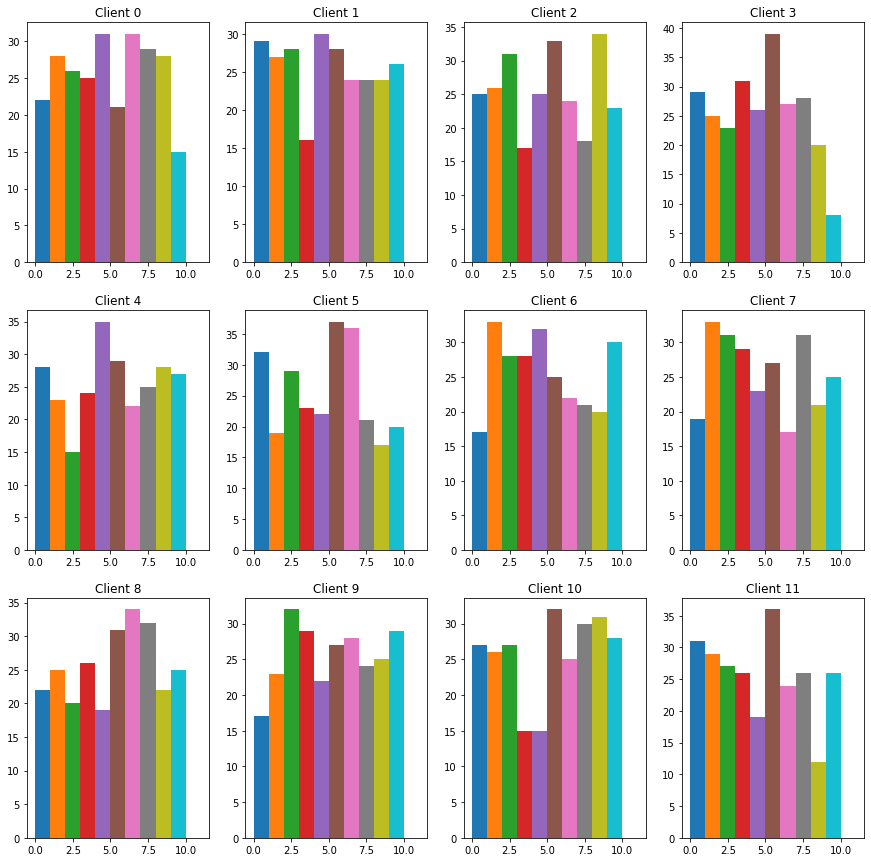

In [40]:

f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = collections.defaultdict(list)
  for [label] in client_dataset[1].tolist():
    plot_data[label].append(label)
  plt.subplot(3,4,i+1)
  plt.title('Client {}'.format(i))
  for j in range(CLASS_NUM):
    plt.hist(
        plot_data[j],
        density = False,
        bins = [x for x in range(len(plot_data)+1)]
    )

显示一下数字与字母的对比


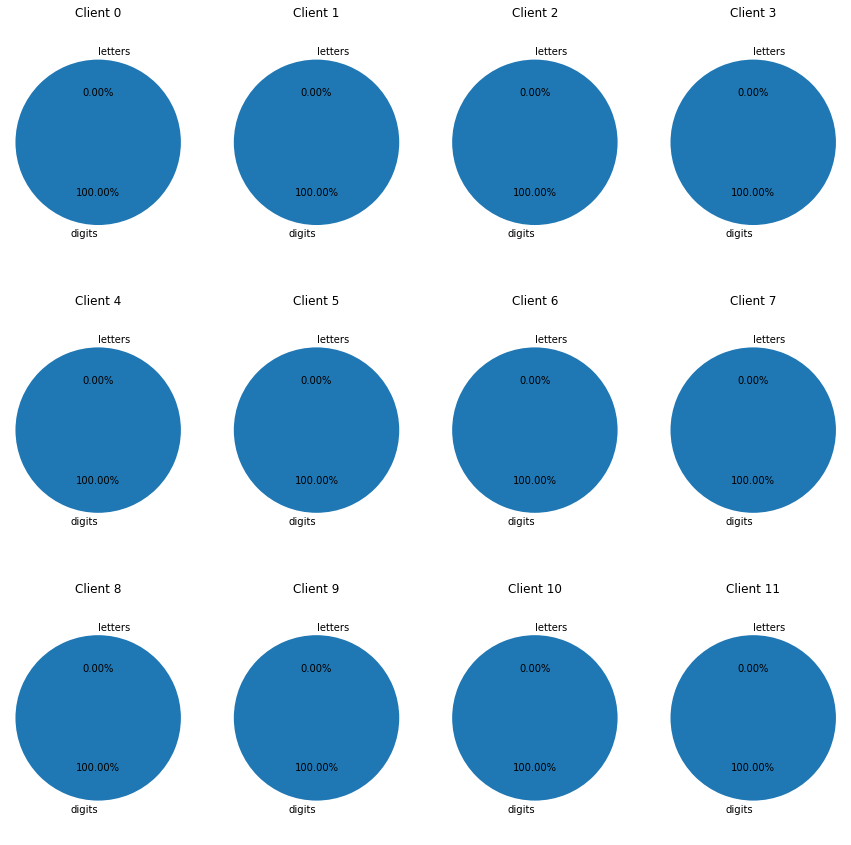

In [41]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = {0:0,1:0}
  plot_labels = ['digits','letters']
  for label in client_dataset[1]:
    label = 0 if label < 10 else 1
    plot_data[label]+=1
  # print(plot_data)
  data_labels = list(sorted(plot_data.keys()))
  # print(data_labels)
  data_nums = [plot_data[i] for i in data_labels]
  colors = ['red','blue']
  plt.subplot(3,4,i+1)
  patches,text1,text2 = plt.pie(data_nums,
                              labels=plot_labels,
                              autopct='%3.2f%%',
                              shadow=False,
                              startangle=90,
                              pctdistance=0.6)
  plt.axis('equal')
  plt.title('Client {}'.format(i))
plt.show()


#阶段二：中央服务器下发模型

Distance Between two models

In [42]:
def Distance(HookModel,TestModel):
  len_it = len(HookModel.trainable_variables)
  Hook_weights=[]
  Test_weights=[]
  for index in range(len_it):
    Hook_weights.append(HookModel.trainable_variables[index].numpy().reshape(-1,))
    Test_weights.append(TestModel.trainable_variables[index].numpy().reshape(-1,))
  target = []
  dis_norm2=[]
  for i in range(len_it):
    target.append(Hook_weights[i]-Test_weights[i])
    dis_norm2.append(np.linalg.norm(target[i],2))
  weight_weights = np.ones([len_it,1])
  #调整权重
  # weight_weights[0]=0
  # weight_weights[1]=0
  dis = np.dot(dis_norm2,weight_weights)
  return dis

In [43]:
def GetDistDict(Clients,Clients_Num,TargetModel):
  """
  return {'client id':Distance(TargetModel,client_id.model)}
  """
  DistDict = collections.OrderedDict()
  for i in range(Clients_Num):
    DistDict[i] = Distance(TargetModel,Clients[i].model)
  return DistDict

In [44]:
def ParticipatedNode(AccuracyList,AccThreshold=0.05):
  tmp = [i for i in range(len(AccuracyList)) if AccuracyList[i]>AccThreshold]

  if len(tmp):
    return tmp
  else:
    return [i for i in range(len(AccuracyList))]

## Show Result Function

In [45]:
def ShowWeights(WeightsDictList,Epoch):
  """
  WeightDict[0] is a array.
  WeightDict[0][0] is a number. 
  """
  WeightDict = WeightsDictList[Epoch]
  labels = ["Client {}".format(i) for i in WeightDict.keys() if WeightDict[i][0]]
  x = [WeightDict[i][0] for i in WeightDict.keys() if WeightDict[i][0]]
  plt.pie(x=x,labels=labels,autopct="%1.2f%%")
  plt.title("The Weight Rate during Epoch {}".format(Epoch))
  plt.show()

In [81]:
def ShowAccAndLoss(LossAndAccList):
  """
  LossAndAccList:[[loss0,acc0],[loss1,acc1]...]
  """
  #deal the data
  IterTimes = len(LossAndAccList)
  Acc = [LossAndAccList[i][1]*100 for i in range(IterTimes)]
  Loss = [LossAndAccList[i][0] for i in range(IterTimes)]
  
  #prepare show image
  x = np.arange(IterTimes).astype(dtype=np.str)
  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  acc = ax1.plot(x,Acc,'r',label='Acc')
  ax1.set_ylabel('Acc(%)')
  ax1.set_xlabel("Epochs")
  ax1.set_title('Acc-Loss (Digits=100%)')

  ax2 = ax1.twinx()
  loss = ax2.plot(x,Loss,label='Loss')
  ax2.set_ylabel('Loss')


  lns = acc+loss
  labs = [l.get_label() for l in lns]
  ax2.legend(lns,labs)
  plt.show()
  return Acc

In [80]:
def ShowParticipatedNode(NodeList):
  """
  NodeList:[[1,2,3,...],[4,5,6,...],...]
  """
  #deal the data
  IterTimes = len(NodeList)
  img = np.ones(shape=(NUM_CLIENTS,IterTimes),dtype=int)
  for i in range(IterTimes):
    for j in NodeList[i]:
      img[j][i]=0
  #prepare show image

  ax = plt.gca()
  ax.set_ylim(-0.5,NUM_CLIENTS-0.5)
  ax.set_xlim(-0.5,9.5)
  miloc = plt.MultipleLocator(1)
  ax.xaxis.set_minor_locator(miloc)
  plt.grid()

  plt.imshow(img*255,cmap='gray')
  plt.axis('on')
  plt.xlabel('Epochs')
  plt.ylabel('Nodes')
  plt.title("Nodes in each epoch (Digits=100%)")
  y = np.arange(0.5,NUM_CLIENTS+0.5,1)
  x = np.arange(0.5,NUM_EPOCHS+0.5,1)

  plt.yticks(y,(int(i-0.5) for i in y))
  plt.xticks(x,(int(i-0.5) for i in x))
  plt.show()

In [65]:
def ResultAnalysis(NewFedAvgAcc,FedBaselineAcc):
  assert len(NewFedAvgAcc)==len(FedBaselineAcc)
  iters = np.arange(len(NewFedAvgAcc)).astype(dtype=np.str)
  fig = plt.figure()
  plt.title("Result Analysis (Digits=100%)")
  # plt.title("Result Analysis (Digits=70%)")
  # plt.title("Result Analysis (Digits=random)")
  plt.plot(iters,NewFedAvgAcc,color='red',label="FedwithAcc")
  plt.plot(iters,FedBaselineAcc,color='blue',label="FedAvg")
  plt.legend()
  plt.xlabel("iteration times")
  plt.ylabel("Accuracy (%)")
  plt.xlim(0,20)
  plt.show()

## Model Initialization

In [71]:
InitModel = FLModel(row=28,col=28,num_classes=CLASS_NUM)
S = ParamServer("")
S.PreEval(InitModel,validation_data)
SendModel = InitModel

7/7 [==============================] - 0s 4ms/step - loss: 2.3897 - accuracy: 0.1387


In [50]:
#InitModel.model.summary()

使用随机初始化的模型进行预测，不预测也可以！

In [51]:
# SendModel = S.PreTrain(InitModel,ShareData,ShareLabel,epochs=1)
# S.PreEval(SendModel,validation_data)

# 阶段三：Clients 训练节点数据并聚合


In [52]:
def FedAvgwithAcc(NUM_CLIENTS,model,AccuracyList,Threshold=0):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []

  NodeDict = GetDistDict(Clients=clients,Clients_Num=NUM_CLIENTS,TargetModel=iterModel)
  FedNodeList = ParticipatedNode(AccuracyList=AccuracyList,AccThreshold=Threshold) # AccThreshold = "-1" means that each one participate FedAvg.

  print("FedNodeList is ",FedNodeList)
  # mult = [AccuracyList[i]/np.exp(NodeDict[i]) for i in range(NUM_CLIENTS)] # no threshold
  mult = [AccuracyList[i]/np.exp(NodeDict[i]) for i in FedNodeList] 
  # print("The Distance are ...",NodeDict)
  # print("The AD are ...",mult)
  exp_sum = np.sum(mult)
  
  #---Prevent an extreme situation---
  if exp_sum <1e-5: # Maybe all of the Acc are 0.
    for i in FedNodeList:
      AccuracyList[i] = np.array([1.])
    # mult = [AccuracyList[i]/np.exp(NodeDict[i]) for i in FedNodeList] 
    mult = AccuracyList
    exp_sum = np.sum(mult)
  #---end---

  Weights = {k:v for (k,v) in zip(FedNodeList,mult/exp_sum)}
  print("Weights are...",Weights)
  ###Softmax

  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in FedNodeList:
    # for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()*Weights[node]
    all_weights.append(tmp)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return (iterModel,FedNodeList,Weights)

In [72]:
NodeList=[]
ACC_Client_Test=[]
WeightsEachEpoch = []
AccMin=0
for e in range(NUM_EPOCHS):
  Acc_tmp=[]
  Weight_tmp=[]
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    Acc_tmp.append(clients[i].NodeEval()[1])

  FedModel,li,Weight_tmp = FedAvgwithAcc(NUM_CLIENTS,SendModel,AccuracyList=Acc_tmp,Threshold=AccMin)
  AccMin = np.mean(Acc_tmp)
  #---Recording---
  NodeList.append(li)
  WeightsEachEpoch.append(Weight_tmp)
  ACC_Client_Test.append(Acc_tmp)
  print("The Acc on each client...",Acc_tmp)
  #---Testing---
  S.PreEval(FedModel,validation_server)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 2.2075 - accuracy: 0.2250
FedNodeList is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Weights are... {0: array([0.09030264]), 1: array([0.15313085]), 2: array([0.08981259]), 3: array([0.05825363]), 4: array([0.08334749]), 5: array([0.0941655]), 6: array([0.06758764]), 7: array([0.0415588]), 8: array([0.05265658]), 9: array([0.10235413]), 10: array([0.09817532]), 11: array([0.06865484])}
The Acc on each client... [0.25999999046325684, 0.41999998688697815, 0.2750000059604645, 0.20000000298023224, 0.25, 0.29499998688697815, 0.1850000023841858, 0.11500000208616257, 0.1550000011920929, 0.3100000023841858, 0.29499998688697815, 0.22499999403953552]
7/7 [==============================] - 0s 4ms/step - loss: 2.1848 - accuracy: 0.2119
EPOCHS 1 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 1.7028 - accuracy: 0.5950
FedNodeList is  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Weights are... {0: arra

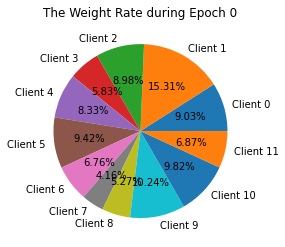

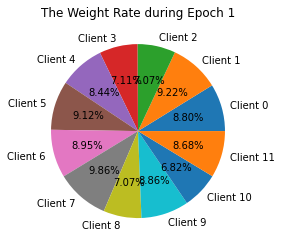

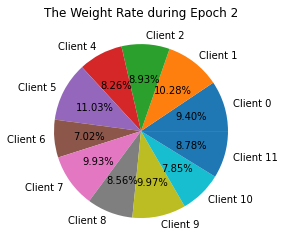

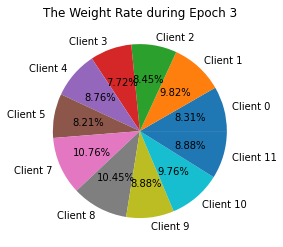

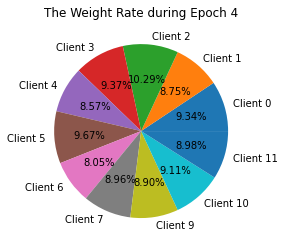

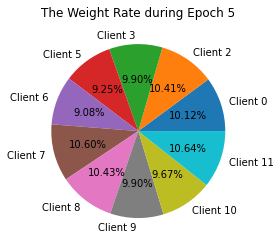

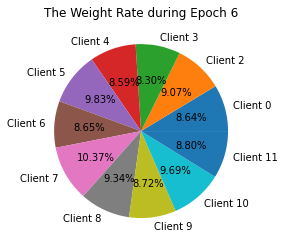

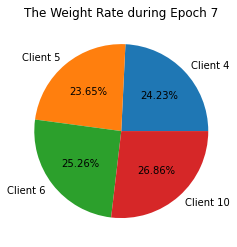

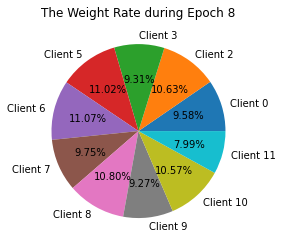

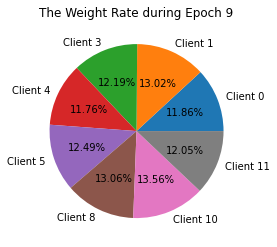

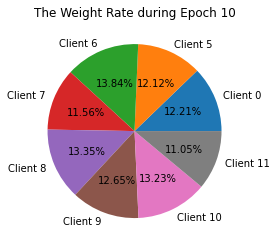

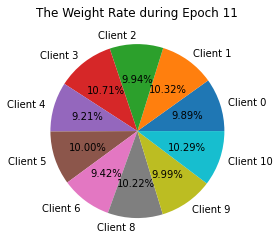

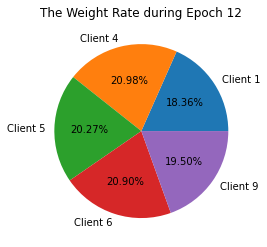

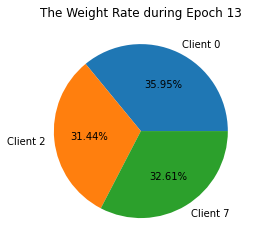

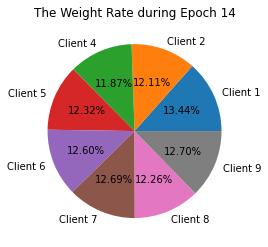

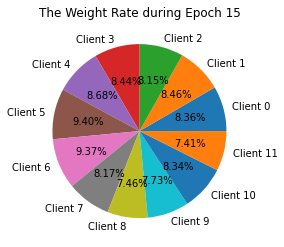

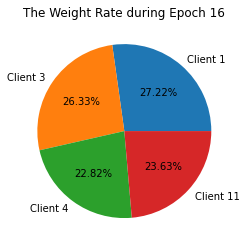

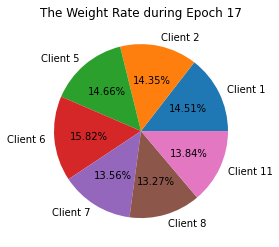

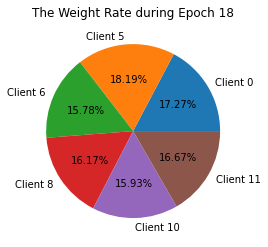

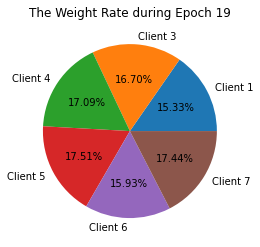

In [73]:
for i in range(NUM_EPOCHS):
  ShowWeights(WeightsEachEpoch,i)

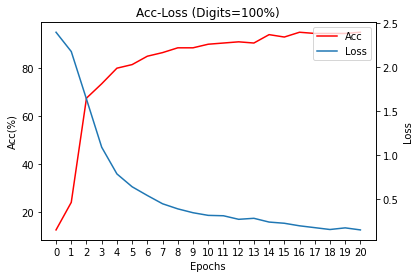

In [82]:
A1 = ShowAccAndLoss(S.loss_acc)

In [75]:
NodeList

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11],
 [0, 2, 3, 5, 6, 7, 8, 9, 10, 11],
 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [4, 5, 6, 10],
 [0, 2, 3, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 3, 4, 5, 8, 10, 11],
 [0, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 8, 9, 10],
 [1, 4, 5, 6, 9],
 [0, 2, 7],
 [1, 2, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [1, 3, 4, 11],
 [1, 2, 5, 6, 7, 8, 11],
 [0, 5, 6, 8, 10, 11],
 [1, 3, 4, 5, 6, 7]]

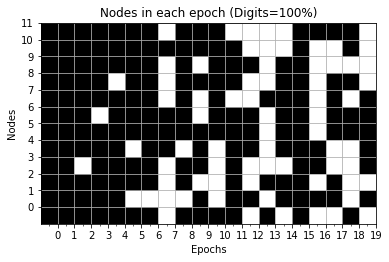

In [83]:
ShowParticipatedNode(NodeList)

# 阶段四：设置对照组，即普通的FedAvg

In [58]:
def FedAvg_Baseline(NUM_CLIENTS,model):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')
    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/NUM_CLIENTS)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [67]:
InitModel = FLModel(row=28,col=28,num_classes=CLASS_NUM)
S2 = ParamServer("")
S2.PreEval(InitModel,validation_data)
SendModel = InitModel

7/7 [==============================] - 0s 4ms/step - loss: 2.4213 - accuracy: 0.0208


In [60]:
# SendModel = S2.PreTrain(InitModel,DigitDataSet[0][0:200],DigitDataSet[1][0:200],epochs=1)
# S2.PreEval(SendModel,validation_data)

In [68]:
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel = FedAvg_Baseline(NUM_CLIENTS,SendModel)
  S2.PreEval(FedModel,validation_server)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 2.2549 - accuracy: 0.3075
EPOCHS 1 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 1.8052 - accuracy: 0.5251
EPOCHS 2 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 1.1409 - accuracy: 0.7665
EPOCHS 3 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 0.7990 - accuracy: 0.7946
EPOCHS 4 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.8070
EPOCHS 5 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 0.5278 - accuracy: 0.8510
EPOCHS 6 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 0.4385 - accuracy: 0.8812
EPOCHS 7 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 0.3888 - accuracy: 0.8931
EPOCHS 8 is starting...
7/7 [==============================] - 0s 4ms/step - loss: 0.3381 - accuracy: 0.9068
EPOCHS 9 is startin

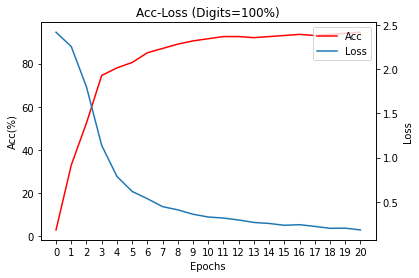

In [84]:
A2 = ShowAccAndLoss(S2.loss_acc)

# 实验结果对比

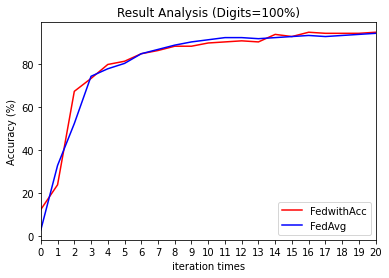

In [85]:
ResultAnalysis(A1,A2)